<a href="https://colab.research.google.com/github/anampavicic/SGAI-Final-Project/blob/main/nlp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
with open('/content/drive/MyDrive/graph_with_content.pickle', 'rb') as f:
   G_loaded = pickle.load(f)
print(len(G_loaded.edges()))

26808


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf
import polars as pl
import os
import pandas as pd
import numpy as np

In [4]:
def get_transformers_word_embeddings(model: AutoModel):
    return model.embeddings.word_embeddings.weight.data.to("cpu").numpy()

def generate_embeddings_with_transformers(
    model: AutoModel,
    tokenizer: AutoTokenizer,
    text_list: list[str],
    batch_size: int = 8,
    device: str = None,
    disable_tqdm: bool = False,
) -> torch.Tensor:
    """
    Generates embeddings for a list of texts using a pre-trained transformer model.

    Args:
        model_name (str): The name of the pre-trained transformer model to use.
        text_list (list of str): A list of texts to generate embeddings for.
        batch_size (int): The batch size to use for generating embeddings. Defaults to 8.
        device (str): The device to use for generating embeddings (e.g., "cpu", "cuda").
            If None, defaults to the first available GPU or CPU.

    Returns:
        embeddings (torch.Tensor): A tensor containing the embeddings for the input texts.
            The shape of the tensor is (num_texts, embedding_dim), where num_texts is the number
            of input texts and embedding_dim is the dimensionality of the embeddings produced by
            the pre-trained model.

    Examples:
    >>> model_name = "bert-base-uncased"
    >>> text_list = ["hello world", "how are you"]
    >>> batch_size = 2
    >>> device = "cpu"
    >>> model = AutoModel.from_pretrained(model_name)
    >>> tokenizer = AutoTokenizer.from_pretrained(model_name)
    >>> embeddings_tensor = generate_embeddings_with_transformers(model, tokenizer, text_list, batch_size, device)
    >>> print(embeddings_tensor)
        tensor([[-0.0243,  0.1144,  0.0830,  ..., -0.2666,  0.1662,  0.1519],
                [ 0.0827,  0.0877, -0.0688,  ..., -0.4381,  0.0462, -0.1446]])
    >>> print(embeddings_tensor.shape)
        torch.Size([2, 768])
    """
    device = get_torch_device(use_gpu=True) if device is None else device
    model = model.to(device)

    tokenized_text = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    feature_names = list(tokenized_text)

    dataset = TensorDataset(
        tokenized_text["input_ids"], tokenized_text["attention_mask"]
    )
    dataloader = DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Encoding", disable=disable_tqdm):
            inputs = {feat: t.to(device) for feat, t in zip(feature_names, batch)}
            outputs = model(
                **inputs,
                output_hidden_states=True,
            )
            embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze(dim=1))
    return torch.vstack(embeddings)


def convert_text2encoding_with_transformers(
    df: pl.DataFrame,
    tokenizer: AutoTokenizer,
    column: str,
    max_length: int = 512,
) -> pl.DataFrame:
    """Converts text in a specified DataFrame column to tokens using a provided tokenizer.
    Args:
        df (pl.DataFrame): The input DataFrame containing the text column.
        tokenizer (AutoTokenizer): The tokenizer to use for encoding the text. (from transformers import AutoTokenizer)
        column (str): The name of the column containing the text.
        max_length (int, optional): The maximum length of the encoded tokens. Defaults to None.
    Returns:
        pl.DataFrame: A new DataFrame with an additional column containing the encoded tokens.
    Example:
    >>> from transformers import AutoTokenizer
    >>> import polars as pl
    >>> df = pl.DataFrame({
            'text': ['This is a test.', 'Another test string.', 'Yet another one.']
        })
    >>> tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    >>> encoded_df, new_column = convert_text2encoding_with_transformers(df, tokenizer, 'text', max_length=20)
    >>> print(encoded_df)
        shape: (3, 2)
        ┌──────────────────────┬───────────────────────────────┐
        │ text                 ┆ text_encode_bert-base-uncased │
        │ ---                  ┆ ---                           │
        │ str                  ┆ list[i64]                     │
        ╞══════════════════════╪═══════════════════════════════╡
        │ This is a test.      ┆ [2023, 2003, … 0]             │
        │ Another test string. ┆ [2178, 3231, … 0]             │
        │ Yet another one.     ┆ [2664, 2178, … 0]             │
        └──────────────────────┴───────────────────────────────┘
    >>> print(new_column)
        text_encode_bert-base-uncased
    """
    text = df[column].to_list()
    # set columns
    new_column = f"{column}_encode_{tokenizer.name_or_path}"
    # If 'max_length' is provided then set it, else encode each string its original length
    padding = "max_length" if max_length else False
    encoded_tokens = tokenizer(
        text,
        add_special_tokens=False,
        padding=padding,
        max_length=max_length,
        truncation=True,
    )["input_ids"]
    return df.with_columns(pl.Series(new_column, encoded_tokens)), new_column

def concat_str_columns(df: pl.DataFrame, columns: list[str]) -> pl.DataFrame:
    """
    >>> df = pl.DataFrame(
            {
                "id": [1, 2, 3],
                "first_name": ["John", "Jane", "Alice"],
                "last_name": ["Doe", "Doe", "Smith"],
            }
        )
    >>> concatenated_df, concatenated_column_name = concat_str_columns(df, columns=['first_name', 'last_name'])
    >>> concatenated_df
        shape: (3, 4)
        ┌─────┬────────────┬───────────┬──────────────────────┐
        │ id  ┆ first_name ┆ last_name ┆ first_name-last_name │
        │ --- ┆ ---        ┆ ---       ┆ ---                  │
        │ i64 ┆ str        ┆ str       ┆ str                  │
        ╞═════╪════════════╪═══════════╪══════════════════════╡
        │ 1   ┆ John       ┆ Doe       ┆ John Doe             │
        │ 2   ┆ Jane       ┆ Doe       ┆ Jane Doe             │
        │ 3   ┆ Alice      ┆ Smith     ┆ Alice Smith          │
        └─────┴────────────┴───────────┴──────────────────────┘
    """
    concat_name = "-".join(columns)
    concat_columns = df.select(pl.concat_str(columns, separator=" ").alias(concat_name))
    return df.with_columns(concat_columns), concat_name


In [5]:
print(G_loaded.nodes())

['Sochi', 'Kazan', 'Astrakhan', 'Mineralnye Vody', 'Chelyabinsk', 'Novosibirsk', 'Moscow', 'Taganrog', 'Belgorod', 'Kaliningrad', 'Baku', 'St. Petersburg', 'Yekaterinburg', 'Nizhnevartovsk', 'Novy Urengoy', 'Bratsk', 'Irkutsk', 'Kirensk', 'Bodaibo', 'Ust-Kut', 'Lensk', 'Yakutsk', 'Ayacucho', 'Lima', 'Cuzco', 'Puerto Maldonado', 'Huánuco', 'Iquitos', 'Pucallpa', 'Tarapoto', 'Abidjan', 'Ouagadougou', 'Accra', 'Bamako', 'Dakar', 'Cotonou', 'Lome', 'Niamey', 'Bogota', 'Guayaquil', 'Quito', 'Cali', 'Coca', 'Brindisi', 'Zurich', 'Bordeaux', 'Bristol', 'Geneva', 'Gran Canaria', 'Larnaca', 'Marsa Alam', 'Tenerife', 'Arvidsjaur', 'Lycksele', 'Stockholm', 'Gallivare', 'Halmstad', 'Joenkoeping', 'Karlstad', 'Mariehamn', 'Ornskoldsvik', 'Pori', 'Sandefjord', 'Visby', 'Vilhelmina', 'Vaxjo', 'Hemavan', 'Kruunupyy', 'Turku', 'Oslo', 'Larsen Bay', 'Manila', 'Butuan', 'Cotabato', 'Cagayan de Oro City', 'Dumaguete', 'Dubai', 'Romblon', 'Kalibo', 'Caticlan', 'Ozamis', 'Puerto Princesa', 'Roxas City', 'Sa

In [6]:
import os
import polars as pl

# Initialize an empty DataFrame with the required columns and explicit types
text_df = pl.DataFrame({"node": pl.Series([], dtype=pl.Utf8),
                        "history": pl.Series([], dtype=pl.Utf8),
                        "demography": pl.Series([], dtype=pl.Utf8)})

# Process files in the `history` folder
for filename in os.listdir('/content/drive/MyDrive/history'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G_loaded.nodes():
        with open(os.path.join('/content/drive/MyDrive/history', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "history": [content], "demography": [None]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Process files in the `demography` folder
for filename in os.listdir('/content/drive/MyDrive/demography'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G_loaded.nodes():
        with open(os.path.join('/content/drive/MyDrive/demography', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "history": [None], "demography": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Combine rows for the same `node` manually
nodes = text_df["node"].unique()
aggregated_data = []

for node in nodes:
    node_data = text_df.filter(text_df["node"] == node)
    history = node_data["history"].drop_nulls().to_list()[0] if not node_data["history"].drop_nulls().is_empty() else None
    demography = node_data["demography"].drop_nulls().to_list()[0] if not node_data["demography"].drop_nulls().is_empty() else None
    aggregated_data.append({"node": node, "history": history, "demography": demography})

text_df = pl.DataFrame(aggregated_data)


In [7]:
text_df

node,history,demography
str,str,str
"""Pune""","""=== Early and Medieval Period …","""The city has a population of 3…"
"""Villahermosa""","""Image:Villahermosa.Plaza de Ar…","""* According to the World Popul…"
"""Barnaul""","""=== Ancient history === The ar…","""As of 2021, the ethnic composi…"
"""Jiuzhaigou""","""Jiuzhaigou (literally ""Nine Se…",null
"""Skelleftea""","""The name Skellefteå is recorde…",null
…,…,…
"""Tasiujaq""","""The French fur company Révillo…","""In the 2021 Canadian census|20…"
"""Lahore""","""=== Origins === No definitiv…","""=== Population === The results…"
"""Cambridge Bay""","""The first known people to occu…","""In the 2021 Canadian census co…"


In [8]:
demography_df = text_df.select(["node", "demography"])
demography_df = demography_df.with_columns(pl.col("demography").cast(pl.Utf8))
demography_df = demography_df.filter(pl.col("demography").is_not_null())


## Economy processing

In [9]:
TRANSFORMER_MODEL_NAME = "dslim/bert-base-NER"
TEXT_COLUMNS_TO_USE = ['demography']

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
demography_embeddings_df, token_col_title = convert_text2encoding_with_transformers(demography_df, transformer_tokenizer, TEXT_COLUMNS_TO_USE[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
demography_embeddings_df.head()

node,demography,demography_encode_dslim/bert-base-NER
str,str,list[i64]
"""Pune""","""The city has a population of 3…","[1109, 1331, … 141]"
"""Villahermosa""","""* According to the World Popul…","[115, 1792, … 0]"
"""Barnaul""","""As of 2021, the ethnic composi…","[1249, 1104, … 0]"
"""Utila""","""= The people of Utila are of A…","[134, 1109, … 0]"
"""Mount Isa""","""In 2008, a rumour circulated t…","[1130, 1369, … 0]"


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cities = demography_embeddings_df['node'].to_list()
embeddings = np.vstack(demography_embeddings_df[token_col_title].to_list())

# Compute the cosine similarity matrix
cosine_similarities = cosine_similarity(embeddings)

# Put in a dataframe
cosine_similarities_dslim = pd.DataFrame(cosine_similarities, index=cities, columns=cities)

In [12]:
print("Mean: ", cosine_similarities_dslim.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_dslim.mean().max())
print("Min: ", cosine_similarities_dslim.mean().min())
print("Median: ", cosine_similarities_dslim.mean().median())
print("Std: ", cosine_similarities_dslim.mean().std())

Mean:  0.191299989078129
Max:  0.2755961611045146
Min:  0.0
Median:  0.19750118069528014
Std:  0.03843979975355547


In [13]:
import networkx as nx
G_demo = nx.Graph()

for city1 in cosine_similarities_dslim.index:
    for city2 in cosine_similarities_dslim.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_dslim.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_demo.add_edge(city1, city2, weight=weight)

In [14]:
'''import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(G_demo)  # Position nodes using a spring layout
plt.figure(figsize=(10, 8))

# Draw nodes and labels
nx.draw_networkx_nodes(G_demo, pos, node_size=100)

# Draw edges with width proportional to weights
edges = G_demo.edges(data=True)
nx.draw_networkx_edges(
    G_demo,
    pos,
    edgelist=[(u, v) for u, v, _ in edges],
    width=[d['weight'] * 5 for _, _, d in edges]  # Scale weights for better visibility
)

# Add edge labels (weights)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G_demo, pos, edge_labels=edge_labels, font_size=10)

plt.title("Graph Representation of Cosine Similarities")
plt.axis("off")  # Turn off the axes
plt.show()'''

'import matplotlib.pyplot as plt\n\n# Draw the graph\npos = nx.spring_layout(G_demo)  # Position nodes using a spring layout\nplt.figure(figsize=(10, 8))\n\n# Draw nodes and labels\nnx.draw_networkx_nodes(G_demo, pos, node_size=100)\n\n# Draw edges with width proportional to weights\nedges = G_demo.edges(data=True)\nnx.draw_networkx_edges(\n    G_demo,\n    pos,\n    edgelist=[(u, v) for u, v, _ in edges],\n    width=[d[\'weight\'] * 5 for _, _, d in edges]  # Scale weights for better visibility\n)\n\n# Add edge labels (weights)\nedge_labels = {(u, v): f"{d[\'weight\']:.2f}" for u, v, d in edges}\nnx.draw_networkx_edge_labels(G_demo, pos, edge_labels=edge_labels, font_size=10)\n\nplt.title("Graph Representation of Cosine Similarities")\nplt.axis("off")  # Turn off the axes\nplt.show()'

In [15]:
#Save as pickle
import pickle
with open('/content/drive/MyDrive/graph_with_demography.pickle', 'wb') as f:
   pickle.dump(G_demo, f)

In [16]:
print("Nodes ", len(G_demo.nodes()))
print("Edges ", len(G_demo.edges()))

Nodes  1239
Edges  766941


## History Processing

In [17]:
history_df = text_df.select(["node", "history"])
history_df = history_df.with_columns(pl.col("history").cast(pl.Utf8))
history_df = history_df.filter(pl.col("history").is_not_null())

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# get all the tokens that refer to the same genre
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#stop_words.update(['http','title', 'short', 'description', ' ', 'wa'])

city_history_dict = {}
for row in history_df.iter_rows(named=True):
    city = row["node"]
    city_text = row["history"]

    # Tokenize text
    tokens = word_tokenize(city_text)
    # Convert to lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # remove single characters
    tokens = [word for word in tokens if len(word) > 1]

    content = " ".join(tokens)
    city_history_dict[city] = content


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF for each genre
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(city_history_dict.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

In [20]:
cities = history_df['node'].to_list()
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

cosine_similarities_tfidf = pd.DataFrame(cosine_sim_matrix, index=cities, columns=cities)

In [21]:
print("Mean: ", cosine_similarities_tfidf.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf.mean().max())
print("Min: ", cosine_similarities_tfidf.mean().min())
print("Median: ", cosine_similarities_tfidf.mean().median())
print("Std: ", cosine_similarities_tfidf.mean().std())

Mean:  0.028722871998572774
Max:  0.0718059580190065
Min:  0.0
Median:  0.028076120887680286
Std:  0.009498972336203238


In [22]:
# Extract top 100 words for each city
top_words_per_city = {}
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    # Get indices of top 100 words based on TF-IDF scores
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    # Get actual words using feature names
    top_words = [feature_names[i] for i in top_word_indices]
    top_words_per_city[city] = top_words

# Filter TF-IDF matrix to include only top words
all_top_words = set().union(*top_words_per_city.values())  # Combine top words from all cities
top_word_indices = [i for i, word in enumerate(feature_names) if word in all_top_words]
filtered_tfidf_matrix = tfidf_matrix[:, top_word_indices]

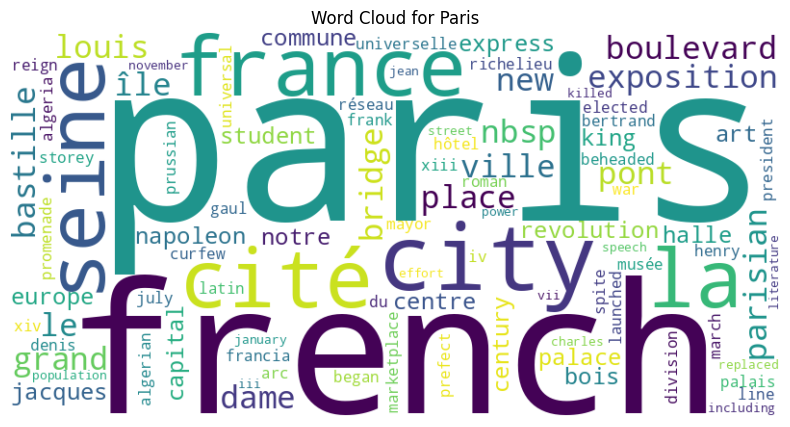

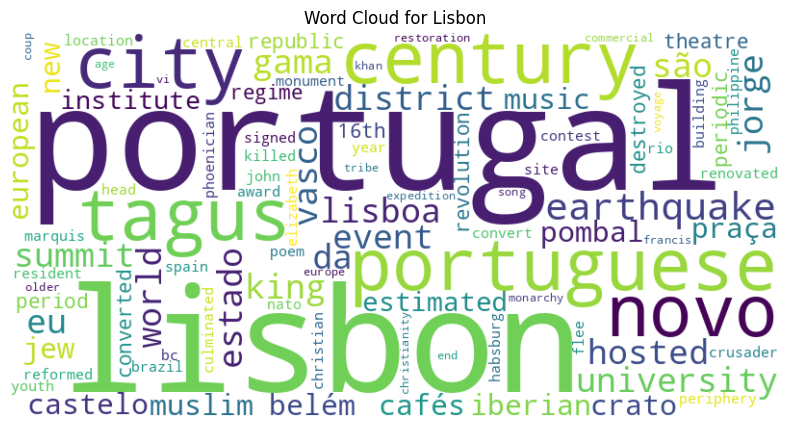

In [23]:
#see word clouds from top 100 words of 2 cities
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for city in cities:
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_words_per_city[city]))

    # Display the generated Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {city}")


In [24]:
cosine_similarities_tfidf_top = cosine_similarity(filtered_tfidf_matrix)
cosine_similarities_tfidf_top = pd.DataFrame(cosine_similarities_tfidf_top, index=cities, columns=cities)
cosine_similarities_tfidf_top

ValueError: Shape of passed values is (1946, 1946), indices imply (2, 2)

In [ ]:
print("Mean: ", cosine_similarities_tfidf_top.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf_top.mean().max())
print("Min: ", cosine_similarities_tfidf_top.mean().min())
print("Median: ", cosine_similarities_tfidf_top.mean().median())
print("Std: ", cosine_similarities_tfidf_top.mean().std())

In [ ]:
G_hist = nx.Graph()

for city1 in cosine_similarities_tfidf.index:
    for city2 in cosine_similarities_tfidf.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_tfidf.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_hist.add_edge(city1, city2, weight=weight)

In [ ]:
#Save as pickle
import pickle
with open('/content/drive/MyDrive/graph_with_history.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [ ]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

## LDA

In [26]:
import re
#find number of subsections in text file
def find_all_sections(wiki_content):
    # Match any section with = signs (e.g., ===Section===) and its content
    pattern = r'(={2,}\s*[^=\n]+\s*={2,})([\s\S]*?)(?=\n={2,}[^=]+=*|\Z)'
    matches = re.findall(pattern, wiki_content)

    # Extract section headers and their content into a dictionary
    sections = {}
    for header, content in matches:
        # Clean the header of excess = signs and whitespace
        clean_header = re.sub(r'^={2,}\s*|\s*={2,}$', '', header).strip()
        sections[clean_header] = content.strip()

    return sections

In [42]:
import statistics
cities = history_df['node'].to_list()

sub_sections = {}
#get subsection count of each city
for city in cities:
    with open(f'/content/drive/MyDrive/history/{city}.txt', 'r', encoding='utf-8') as file:
        wiki_content = file.read()
    sections = find_all_sections(wiki_content)
    sub_sections[city] = len(sections)

#get mean
mean_sub_sections = round(sum(sub_sections.values()) / len(sub_sections))
print(f"Mean number of subsections per city: {mean_sub_sections}")

Mode number of subsections per city: 910
Mode number of subsections per city: 0
Mean number of subsections per city: 2


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = vectorizer.fit_transform(city_history_dict.values())

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tf)

topics = lda.components_  # Word distributions per topic
city_topics = lda.transform(tf)

In [52]:
#compute cosine_similarity for LDA
cosine_similarities_lda = cosine_similarity(city_topics)
cosine_similarities_lda = pd.DataFrame(cosine_similarities_lda, index=cities, columns=cities)

In [36]:
print("Mean: ", cosine_similarities_lda.mean().mean())
print(f'{cosine_similarities_lda.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_lda.mean().max()}')
print(f'{cosine_similarities_lda.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_lda.mean().min()}')
#get the two cities with the highest similarities besides their own

print("Max: ", cosine_similarities_lda.mean().max())
print("Min: ", cosine_similarities_lda.mean().min())
print("Median: ", cosine_similarities_lda.mean().median())
print("Std: ", cosine_similarities_lda.mean().std())

Mean:  0.6147099551705564
Shiquanhe is the city with the most similarities with an average of 0.7840324024518831
Lvov is the city with the least similarities with an average of 0.4988514404944205
Max:  0.7840324024518831
Min:  0.4988514404944205
Median:  0.6081679994119711
Std:  0.08788326667035737


In [59]:
G_hist = nx.Graph()

for city1 in cosine_similarities_lda.index:
    for city2 in cosine_similarities_lda.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_lda.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_hist.add_edge(city1, city2, weight=weight)

In [60]:
#Save as pickle
import pickle
with open('/content/drive/MyDrive/graph_with_history_lda.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [61]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

Nodes  1946
Edges  1892485
